In [4]:
import pandas as pd
import glob

In [5]:
# function to process all individual csv annotations into one dataframe
def return_df_from_files(casualty_directory):
    df = pd.concat([pd.read_csv(f) for f in glob.glob(casualty_directory+'*.csv')])
    
    # make sure we do not have any duplicate sentences for same articles
    df.drop_duplicates(['article_id', 'sentence'], keep = 'first', inplace=True)
    
    return df
    
file_annotations = return_df_from_files('./fatality_counts/')

In [6]:
# otherwise we can load from saved annotations

annotations_articles = pd.read_csv('./fatality_counts/summary/annotations_articles_20231007-20231202.csv')
annotations_livefeeds = pd.read_csv('./fatality_counts/summary/annotations_livefeed_20231007-20231202.csv')

combined = pd.concat([annotations_articles, annotations_livefeeds, file_annotations])

# set to datetime and filter for period of interest
combined['article_date'] = pd.to_datetime(combined['article_date'])
combined = combined[(combined['article_date'] > '2023-10-06')]

print(combined.shape)

(8075, 7)


In [7]:
summary = combined.groupby(['article_date', 'category']).agg({'article_id':'count'}).reset_index().pivot(index='article_date', columns='category', values='article_id').reset_index()

for column in ['both', 'israel', 'palestine']:
    if column not in summary:
        summary[column] = 0
    summary[column].fillna(0, inplace=True)

summary['both'].fillna(0, inplace=True)
summary['israel'] = summary['israel'] + summary['both']
summary['palestine'] = summary['palestine'] + summary['both']

summary.head(5)

category,article_date,both,israel,palestine
0,2023-10-07,2.0,37.0,23.0
1,2023-10-08,4.0,86.0,57.0
2,2023-10-09,10.0,105.0,49.0
3,2023-10-10,1.0,65.0,41.0
4,2023-10-11,11.0,113.0,60.0


In [17]:
summary_grouped = summary.groupby(pd.Grouper(key='article_date', freq='7D')).agg({'israel':'sum', 'palestine':'sum'}).reset_index()
summary_grouped = summary_grouped[summary_grouped['article_date'] < '2024-07-01']

summary_grouped

category,article_date,israel,palestine
0,2023-10-07,511.0,307.0
1,2023-10-14,282.0,276.0
2,2023-10-21,205.0,320.0
3,2023-10-28,190.0,286.0
4,2023-11-04,164.0,322.0
5,2023-11-11,122.0,312.0
6,2023-11-18,112.0,173.0
7,2023-11-25,185.0,170.0
8,2023-12-02,89.0,129.0
9,2023-12-09,107.0,174.0


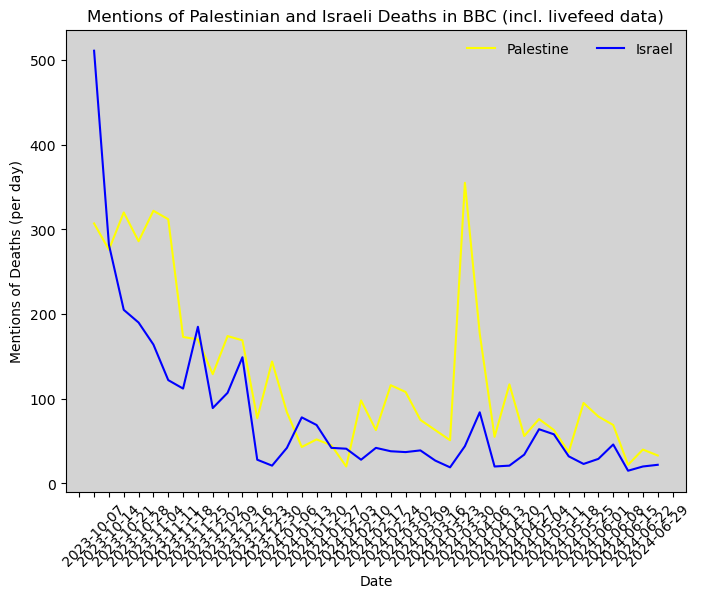

In [18]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

fig, ax = plt.subplots(figsize=(8, 6))

summary_plot = summary_grouped.copy()

dates = summary_plot['article_date'].astype(str).values
 
ax.plot(dates, summary_plot.palestine, label = 'Palestine', color = 'yellow')
ax.plot(dates, summary_plot.israel, label = 'Israel', color = 'blue')

ax.set_title("Mentions of Palestinian and Israeli Deaths in BBC (incl. livefeed data)")
ax.set_xlabel("Date")
ax.set_ylabel("Mentions of Deaths (per day)")

ax.set_facecolor("lightgray")
plt.xticks(rotation=45)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.legend(ncols=2, framealpha=0)

plt.savefig('../outputs/bbc_mentions.png', bbox_inches='tight', dpi=300)